In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
# Reproducibility
import random
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# Data Understanding

In [2]:
df_ratings = pd.read_csv('dataset/ml-latest-small/ratings.csv')
df_tags = pd.read_csv('dataset/ml-latest-small/tags.csv')
df_movies = pd.read_csv('dataset/ml-latest-small/movies.csv')

In [3]:
df_ratings.head(3)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224


Pada data ratings, terdapat 4 variabel :
- userId : nomor unik user
- movieId : nomor unik film
- rating : rating yang diberikan user untuk film
- timestamp :  merepresentasikan jumlah detik sejak tengah malam Waktu Universal Terkoordinasi (UTC) pada tanggal 1 Januari 1970.

In [4]:
df_movies.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


Pada data movies, terdapat 3 variabel :
- movieId : nomor unik film
- title : judul film dengan nomor unik movieId
- genres : genre dari film

In [5]:
df_tags.head(3)

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992


Pada data tags, terdapat 4 variabel :
- userId : nomor unik user
- movieId : nomor unik film
- tag : tag yang diberikan user untuk film
- timestamp : merepresentasikan jumlah detik sejak tengah malam Waktu Universal Terkoordinasi (UTC) pada tanggal 1 Januari 1970.

In [6]:
# Banyak Data
print(f'Banyak data ratings film yang dimiliki : {len(df_ratings)}')
print(f'Banyak data film film yang dimiliki : {len(df_movies)}')
print(f'Banyak data tags film yang dimiliki : {len(df_tags)}')

Banyak data ratings film yang dimiliki : 100836
Banyak data film film yang dimiliki : 9742
Banyak data tags film yang dimiliki : 3683


# Exploratory Data Analysis

In [7]:
df_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


In [8]:
df_tags.isnull().sum()

userId       0
movieId      0
tag          0
timestamp    0
dtype: int64

In [9]:
df_tags[df_tags.duplicated(subset=['userId','movieId'], keep=False)]

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200
...,...,...,...,...
3669,599,2959,twist ending,1498456888
3670,599,2959,violence,1498456904
3671,599,2959,violent,1498456914
3680,610,3265,gun fu,1493843984


Pada data tags, terdapat tag yang terpisah untuk userId dan movieId yang sama.

In [10]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [11]:
df_movies.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [12]:
df_movies[df_movies.duplicated(subset=['title'], keep=False)]

,movieId,title,genres
650,838,Emma (1996),Comedy|Drama|Romance
2141,2851,Saturn 3 (1980),Adventure|Sci-Fi|Thriller
4169,6003,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Thriller
5601,26958,Emma (1996),Romance
5854,32600,Eros (2004),Drama
5931,34048,War of the Worlds (2005),Action|Adventure|Sci-Fi|Thriller
6932,64997,War of the Worlds (2005),Action|Sci-Fi
9106,144606,Confessions of a Dangerous Mind (2002),Comedy|Crime|Drama|Romance|Thriller
9135,147002,Eros (2004),Drama|Romance
9468,168358,Saturn 3 (1980),Sci-Fi|Thriller


Pada data movies, terdapat film yang ditandai dengan nomor unik yang berbeda.

In [13]:
print(f'Banyaknya film yang tersedia : {df_movies.title.nunique()}')

Banyaknya film yang tersedia : 9737


In [14]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [15]:
df_ratings.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [16]:
df_ratings[df_ratings.duplicated(subset=['userId', 'movieId'], keep=False)]

,userId,movieId,rating,timestamp


Tidak terdapat data missing pada ketiga dataframe. Namun terdapat beberapa nilai yang duplikat.

# Data Preparation

In [ ]:
# Membuang fitur yang tidak relevan/tidak digunakan
df_ratings = df_ratings.drop(columns='timestamp')
df_tags = df_tags.drop(columns='timestamp')

Berdasarkan permasalahan yang kita temukan di EDA, terdapat duplikasi tag pada userId dan movieId yang sama. Maka, kita perlu menggabungkannya.

In [18]:
df_tags_cleaned = df_tags.groupby(['movieId','userId']).agg({
    'tag' : lambda x: ' '.join(set(x))
}).reset_index()

In [19]:
df_tags_cleaned.head(5)

,movieId,userId,tag
0,1,336,pixar
1,1,474,pixar
2,1,567,fun
3,2,62,magic board game fantasy Robin Williams
4,2,474,game


Kemudian, kita atasi masalah movie dengan nomor unik yang berbeda.

In [20]:
df_movies_cleaned=df_movies.drop_duplicates(subset='title', keep='first')

In [21]:
df_movies_cleaned.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [22]:
df_rating_tags = pd.merge(df_ratings, df_tags_cleaned, on=['userId', 'movieId'], how='inner')
df_final = pd.merge(df_rating_tags, df_movies_cleaned, on=['movieId'], how='inner')

In [23]:
df_final.head(5)

,userId,movieId,rating,tag,title,genres
0,2,60756,5.0,funny Highly quotable will ferrell,Step Brothers (2008),Comedy
1,2,89774,5.0,MMA Tom Hardy Boxing story,Warrior (2011),Drama
2,2,106782,5.0,drugs Leonardo DiCaprio Martin Scorsese,"Wolf of Wall Street, The (2013)",Comedy|Crime|Drama
3,7,48516,1.0,way too long,"Departed, The (2006)",Crime|Drama|Thriller
4,18,431,4.0,mafia gangster Al Pacino,Carlito's Way (1993),Crime|Drama


## Data Preparation for Content-Based Filtering

In [24]:
df_final_content_based = df_final.copy()

In [25]:
df_final_content_based['genres'] = df_final_content_based['genres'].str.replace('|', ' ', regex=False)

In [26]:
df_final_content_based['extracted_features'] = df_final_content_based['genres'].str.lower() + ' ' + df_final_content_based['tag'].str.lower()

In [27]:
df_final_content_based

,userId,movieId,rating,tag,title,genres,extracted_features
0,2,60756,5.0,funny Highly quotable will ferrell,Step Brothers (2008),Comedy,comedy funny highly quotable will ferrell
1,2,89774,5.0,MMA Tom Hardy Boxing story,Warrior (2011),Drama,drama mma tom hardy boxing story
2,2,106782,5.0,drugs Leonardo DiCaprio Martin Scorsese,"Wolf of Wall Street, The (2013)",Comedy Crime Drama,comedy crime drama drugs leonardo dicaprio mar...
3,7,48516,1.0,way too long,"Departed, The (2006)",Crime Drama Thriller,crime drama thriller way too long
4,18,431,4.0,mafia gangster Al Pacino,Carlito's Way (1993),Crime Drama,crime drama mafia gangster al pacino
...,...,...,...,...,...,...,...
1630,606,5694,3.0,70mm,Staying Alive (1983),Comedy Drama Musical,comedy drama musical 70mm
1631,606,6107,4.0,World War II,Night of the Shooting Stars (Notte di San Lore...,Drama War,drama war world war ii
1632,606,7382,4.5,for katie,I'm Not Scared (Io non ho paura) (2003),Drama Mystery Thriller,drama mystery thriller for katie
1633,610,3265,5.0,gun fu heroic bloodshed,Hard-Boiled (Lat sau san taam) (1992),Action Crime Drama Thriller,action crime drama thriller gun fu heroic bloo...


In [28]:
tf = TfidfVectorizer(analyzer='word',min_df=0.0, stop_words='english')

tf.fit(df_final_content_based['extracted_features'])

tf.get_feature_names_out()

array(['06', '1900s', '1920s', ..., 'zombie', 'zombies', 'zooey'],
      dtype=object)

In [29]:
content_based_tfidf_matrix = tf.fit_transform(df_final_content_based['extracted_features'])

## Data Preparation for Collaborative Filtering Model Based Deep Learning

In [30]:
df_final_collaborative = df_final.copy()

In [31]:
df_final_collaborative

,userId,movieId,rating,tag,title,genres
0,2,60756,5.0,funny Highly quotable will ferrell,Step Brothers (2008),Comedy
1,2,89774,5.0,MMA Tom Hardy Boxing story,Warrior (2011),Drama
2,2,106782,5.0,drugs Leonardo DiCaprio Martin Scorsese,"Wolf of Wall Street, The (2013)",Comedy|Crime|Drama
3,7,48516,1.0,way too long,"Departed, The (2006)",Crime|Drama|Thriller
4,18,431,4.0,mafia gangster Al Pacino,Carlito's Way (1993),Crime|Drama
...,...,...,...,...,...,...
1630,606,5694,3.0,70mm,Staying Alive (1983),Comedy|Drama|Musical
1631,606,6107,4.0,World War II,Night of the Shooting Stars (Notte di San Lore...,Drama|War
1632,606,7382,4.5,for katie,I'm Not Scared (Io non ho paura) (2003),Drama|Mystery|Thriller
1633,610,3265,5.0,gun fu heroic bloodshed,Hard-Boiled (Lat sau san taam) (1992),Action|Crime|Drama|Thriller


In [32]:
# Mengubah userId menjadi list tanpa nilai yang sama
user_ids = df_final_collaborative['userId'].unique().tolist()
print('list userID: ', user_ids)
 
# Melakukan encoding userId
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('encoded userID : ', user_to_user_encoded)
 
# Melakukan proses encoding angka ke ke userId
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('encoded angka ke userID: ', user_encoded_to_user)

list userID:  [2, 7, 18, 21, 49, 62, 63, 76, 103, 106, 112, 119, 125, 132, 138, 161, 166, 167, 177, 184, 193, 205, 226, 256, 274, 289, 291, 300, 305, 318, 319, 327, 336, 356, 357, 419, 424, 435, 439, 462, 474, 477, 487, 506, 509, 513, 520, 533, 537, 567, 573, 599, 606, 610]
encoded userID :  {2: 0, 7: 1, 18: 2, 21: 3, 49: 4, 62: 5, 63: 6, 76: 7, 103: 8, 106: 9, 112: 10, 119: 11, 125: 12, 132: 13, 138: 14, 161: 15, 166: 16, 167: 17, 177: 18, 184: 19, 193: 20, 205: 21, 226: 22, 256: 23, 274: 24, 289: 25, 291: 26, 300: 27, 305: 28, 318: 29, 319: 30, 327: 31, 336: 32, 356: 33, 357: 34, 419: 35, 424: 36, 435: 37, 439: 38, 462: 39, 474: 40, 477: 41, 487: 42, 506: 43, 509: 44, 513: 45, 520: 46, 533: 47, 537: 48, 567: 49, 573: 50, 599: 51, 606: 52, 610: 53}
encoded angka ke userID:  {0: 2, 1: 7, 2: 18, 3: 21, 4: 49, 5: 62, 6: 63, 7: 76, 8: 103, 9: 106, 10: 112, 11: 119, 12: 125, 13: 132, 14: 138, 15: 161, 16: 166, 17: 167, 18: 177, 19: 184, 20: 193, 21: 205, 22: 226, 23: 256, 24: 274, 25: 289,

In [33]:
# Mengubah movieId menjadi list tanpa nilai yang sama
movie_ids = df_final_collaborative['movieId'].unique().tolist()
print('list movieId: ', movie_ids)
 
# Melakukan encoding movieId
movie_to_movie_encoded = {x: i for i, x in enumerate(movie_ids)}
print('encoded movieId : ', movie_to_movie_encoded)
 
# Melakukan proses encoding angka ke ke movieId
movie_encoded_to_movie = {i: x for i, x in enumerate(movie_ids)}
print('encoded angka ke movieId: ', movie_encoded_to_movie)

list movieId:  [60756, 89774, 106782, 48516, 431, 1221, 5995, 44665, 52604, 88094, 144210, 119141, 109487, 2, 110, 410, 2023, 2124, 2953, 3114, 3578, 4223, 5388, 6058, 6534, 6541, 6564, 7153, 8641, 27660, 27706, 27808, 27831, 31658, 33162, 34150, 37729, 38061, 45447, 46723, 46972, 46976, 49130, 49530, 53464, 58047, 59501, 60074, 60126, 61024, 63992, 68848, 71535, 87430, 88405, 96861, 99114, 103042, 104863, 107348, 108190, 111743, 114180, 115149, 116897, 122912, 128360, 135133, 135518, 135536, 136864, 139385, 158966, 168248, 174053, 179401, 183611, 184471, 187593, 187595, 260, 296, 4896, 106489, 101142, 115617, 120635, 1726, 2387, 3052, 5088, 7022, 7254, 8957, 9010, 42632, 58301, 60950, 62434, 67695, 100083, 156371, 158872, 3556, 6323, 6367, 59103, 52287, 293, 54286, 104, 2579, 3793, 4226, 6283, 27156, 193565, 4878, 7147, 97938, 6938, 48780, 126548, 68319, 3, 1101, 50872, 102007, 118696, 6711, 4034, 4995, 6502, 6953, 34405, 55721, 83134, 778, 4612, 4708, 64034, 68954, 71494, 81158, 8245

In [34]:
df_final_collaborative['user_encoded'] = df_final_collaborative['userId'].map(user_to_user_encoded)
df_final_collaborative['movie_encoded'] = df_final_collaborative['movieId'].map(movie_to_movie_encoded)
df_final_collaborative['rating']=df_final_collaborative['rating'].values.astype(np.float64)

In [ ]:
# Shuffling data sebelum displit
df_final_collaborative = df_final_collaborative.sample(frac=1, random_state=42)
df_final_collaborative.head(5)

,userId,movieId,rating,tag,title,genres,user_encoded,movie_encoded
937,474,3897,4.5,music Rolling Stone journalism,Almost Famous (2000),Drama,40,155
1097,474,5995,4.5,Holocaust,"Pianist, The (2002)",Drama|War,40,6
813,474,2761,4.0,robots,"Iron Giant, The (1999)",Adventure|Animation|Children|Drama|Sci-Fi,40,757
607,474,1358,4.5,ex-con,Sling Blade (1996),Drama,40,557
1304,474,8337,4.0,military,"Caine Mutiny, The (1954)",Drama|War,40,1226


In [36]:
min_rating = df_final_collaborative['rating'].min()
max_rating = df_final_collaborative['rating'].max()

x = df_final_collaborative[['user_encoded','movie_encoded']].values
y = df_final_collaborative['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

In [37]:
train_indices = int(0.8 * x.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)
 
x,y

(array([[  40,  155],
        [  40,    6],
        [  40,  757],
        ...,
        [  40,  800],
        [  41,  169],
        [  40, 1053]], dtype=int64),
 array([0.88888889, 0.88888889, 0.77777778, ..., 0.77777778, 0.88888889,
        0.66666667]))

# Model Development Content Based Filtering

Melakukan perhitungan cosine similiarity antar Film

In [38]:
cosine_sim = cosine_similarity(content_based_tfidf_matrix)
cosine_sim_df = pd.DataFrame(cosine_sim, index=df_final_content_based['title'], columns=df_final_content_based['title'])

In [39]:
cosine_sim_df.head(5)

title,Step Brothers (2008),Warrior (2011),"Wolf of Wall Street, The (2013)","Departed, The (2006)",Carlito's Way (1993),"Godfather: Part II, The (1974)","Pianist, The (2002)",Lucky Number Slevin (2006),Fracture (2007),Upside Down: The Creation Records Story (2010),...,"Big Lebowski, The (1998)",Fight Club (1999),Shine (1996),Tom Jones (1963),Gladiator (2000),Staying Alive (1983),"Night of the Shooting Stars (Notte di San Lorenzo, La) (1982)",I'm Not Scared (Io non ho paura) (2003),Hard-Boiled (Lat sau san taam) (1992),John Wick: Chapter Two (2017)
title,,,,,,,,,,,,,,,,,,,,,
Step Brothers (2008),1.000000,0.000000,0.023563,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.238425,0.006184,0.000000,0.042767,0.000000,0.038146,0.000000,0.000000,0.000000,0.000000
Warrior (2011),0.000000,1.000000,0.011768,0.015833,0.012826,0.015035,0.217680,0.019840,0.021313,0.0,...,0.000000,0.003088,0.028682,0.000000,0.019526,0.019051,0.014994,0.019323,0.011362,0.000000
"Wolf of Wall Street, The (2013)",0.023563,0.011768,1.000000,0.068831,0.055759,0.065361,0.015457,0.086253,0.057006,0.0,...,0.108595,0.029145,0.028741,0.037261,0.019567,0.052326,0.015025,0.019362,0.049395,0.050714
"Departed, The (2006)",0.000000,0.015833,0.068831,1.000000,0.075019,0.087938,0.020796,0.116045,0.113876,0.0,...,0.032941,0.053513,0.038668,0.000000,0.026325,0.025684,0.020214,0.093465,0.106098,0.121121
Carlito's Way (1993),0.000000,0.012826,0.055759,0.075019,1.000000,0.853094,0.016847,0.094007,0.062131,0.0,...,0.026685,0.025893,0.031325,0.000000,0.021326,0.020806,0.016375,0.021103,0.053836,0.055273


In [40]:
def recommend_movies(title, cosine_sim_df=cosine_sim_df, top_n=5):
    #Fungsi untuk mendapatkan rekomendasi top n dengan similiarity score tertinggi
    if title not in cosine_sim_df.index:
        return f"Film '{title}' tidak ditemukan di dalam dataset."

    sim_scores = cosine_sim_df.loc[title]

    sim_scores = sim_scores.sort_values(ascending=False)
    return sim_scores.iloc[1:top_n+1]

In [41]:
cosine_sim_df.index = cosine_sim_df.index.astype(str)
cosine_sim_df.columns = cosine_sim_df.columns.astype(str)

In [42]:
# Mendapatkan rekomendasi film lain saat menyukai film 'Sweet Charity (1969)'
recommendation = recommend_movies("Sweet Charity (1969)", top_n=10)

In [43]:
recommendation

title
Gigi (1958)                                                          0.898370
Pretty Woman (1990)                                                  0.858421
Risky Business (1983)                                                0.803002
Midnight Cowboy (1969)                                               0.785842
Lilya 4-Ever (Lilja 4-ever) (2002)                                   0.717695
Mighty Aphrodite (1995)                                              0.621705
Umbrellas of Cherbourg, The (Parapluies de Cherbourg, Les) (1964)    0.595976
Lagaan: Once Upon a Time in India (2001)                             0.431744
White Christmas (1954)                                               0.405152
Gentlemen Prefer Blondes (1953)                                      0.394708
Name: Sweet Charity (1969), dtype: float64

In [44]:
df_final_content_based[df_final_content_based.title=='Sweet Charity (1969)'][['title', 'extracted_features']]

,title,extracted_features
1126,Sweet Charity (1969),comedy drama musical romance prostitution


In [45]:
def find_tag_genres(title):
    result=df_final_content_based[df_final_content_based.title==title].drop_duplicates(subset='title', keep='first')
    return (result[['title', 'extracted_features']])

Memberikan rekomendasi dalam bentuk dataframe

In [46]:
recommendation_df = pd.DataFrame()
for p in recommendation.index:
    df = find_tag_genres(p)
    recommendation_df = pd.concat([recommendation_df, df], ignore_index=True)

In [47]:
recommendation_df

,title,extracted_features
0,Gigi (1958),musical prostitution
1,Pretty Woman (1990),comedy romance prostitution
2,Risky Business (1983),comedy prostitution
3,Midnight Cowboy (1969),drama prostitution
4,Lilya 4-Ever (Lilja 4-ever) (2002),crime drama prostitution
5,Mighty Aphrodite (1995),comedy drama romance adoption prostitution
6,"Umbrellas of Cherbourg, The (Parapluies de Che...",drama musical romance made me cry
7,Lagaan: Once Upon a Time in India (2001),comedy drama musical romance india
8,White Christmas (1954),comedy musical romance christmas
9,Gentlemen Prefer Blondes (1953),comedy musical romance in netflix queue


### Evaluasi dengan Precision@10

Kita mengambil sampel untuk film "Sweet Charity (1969)" dengan genre+tag : comedy drama musical romance prostitution
Kita menentukan rekomendasi relevan dengan ketentuan :
Apabila terdapat minimal satu bagian dari genre atau tag yang sesuai, maka dianggap relevan.
Sehingga, utk K=10 rekomendasi, diperoleh 10 rekomendasi relevan.

In [48]:
precision10 = 10/10
print(f'precision@10 = ', precision10)

precision@10 =  1.0


Diperoleh precision@10, artinya dari 10 rekomendasi yang diberikan, terdapat 10 rekomendasi yang relevan/sesuai.

# Model Development Collaborative Filtering

In [49]:
num_users = len(user_to_user_encoded)
print(num_users)
 
num_movies = len(movie_encoded_to_movie)
print(num_movies)

54
1464


Pembangunan Arsitektur Model

In [50]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.random.set_seed(SEED)
class RecommenderNet(tf.keras.Model):
 
  # Inisialisasi model
  def __init__(self, num_users, num_movies, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    
    self.num_users = num_users
    self.num_movies = num_movies
    self.embedding_size = embedding_size

    # Layer embedding untuk user
    self.user_embedding = layers.Embedding(
        input_dim=num_users,
        output_dim=embedding_size,
        embeddings_initializer='he_normal',
        embeddings_regularizer=keras.regularizers.l2(1e-4)
    )

    # Layer bias untuk user
    self.user_bias = layers.Embedding(
        input_dim=num_users,
        output_dim=1
    )

    # Layer embedding untuk film
    self.movies_embedding = layers.Embedding(
        input_dim=num_movies,
        output_dim=embedding_size,
        embeddings_initializer='he_normal',
        embeddings_regularizer=keras.regularizers.l2(1e-4)
    )

    # Layer bias untuk film
    self.movies_bias = layers.Embedding(
        input_dim=num_movies,
        output_dim=1
    )
 
  # Proses forward (prediksi)
  def call(self, inputs):
    # Ambil vektor embedding dan bias berdasarkan user dan film
    user_vector = self.user_embedding(inputs[:, 0])       # vektor user
    user_bias = self.user_bias(inputs[:, 0])              # bias user
    movies_vector = self.movies_embedding(inputs[:, 1])   # vektor film
    movies_bias = self.movies_bias(inputs[:, 1])          # bias film

    # Hitung kecocokan (dot product) antara user dan film
    dot_user_movies = tf.tensordot(user_vector, movies_vector, axes=2)

    # Tambahkan bias
    x = dot_user_movies + user_bias + movies_bias
    
    # Aktivasi sigmoid untuk mengubah output ke rentang [0, 1]
    return tf.nn.sigmoid(x)
  
model = RecommenderNet(num_users, num_movies, 5) # inisialisasi model
 
# model compile
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [51]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_root_mean_squared_error',
        patience=10, 
        restore_best_weights=True
    )
] # callbacks untuk menghentikan training saat tidak ada perubahan signifikan terhadap validation rmse

history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=32, 
    epochs=100,    # Set ke angka yang cukup besar, early stopping akan menghentikan
    verbose=1,
    validation_data=(x_val, y_val),
    callbacks=callbacks
)

Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0922 - root_mean_squared_error: 0.3007 - val_loss: 0.0737 - val_root_mean_squared_error: 0.2689
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0632 - root_mean_squared_error: 0.2486 - val_loss: 0.0701 - val_root_mean_squared_error: 0.2622
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0484 - root_mean_squared_error: 0.2168 - val_loss: 0.0678 - val_root_mean_squared_error: 0.2577
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0414 - root_mean_squared_error: 0.2000 - val_loss: 0.0668 - val_root_mean_squared_error: 0.2558
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0388 - root_mean_squared_error: 0.1935 - val_loss: 0.0667 - val_root_mean_squared_error: 0.2555
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0378 - root_mean_squared_error: 0.1908 - val_loss: 0.0669 - val_root_mean_squared_error: 0.2562
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss:

In [52]:
# Mendapatkan rekomendasi untuk user dengan nomor unik 474
user_id = df_final_collaborative.userId.sample(1).iloc[0]

In [53]:
# Mengambil film yang belum ditonton oleh user 474
movies_watched = df_final[df_final.userId == user_id]
movies_not_watched = df_final[~df_final['movieId'].isin(movies_watched.movieId.values)]['movieId']
movies_not_watched = list(
    set(movies_not_watched)
    .intersection(set(movie_to_movie_encoded.keys()))
)

In [54]:
movies_not_watched = [[movie_to_movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user_to_user_encoded.get(user_id)

In [55]:
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)

In [56]:
ratings = model.predict(user_movie_array).flatten() #melakukan prediksi rating yang dinormalisasi

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [57]:
top_ratings_indices = ratings.argsort()[-10:][::-1] # mengambil film dengan nilai prediksi rating tertinggi

In [58]:
top_ratings_indices

array([142, 145, 150, 147, 132, 140, 130, 157, 153, 154], dtype=int64)

In [59]:
recommended_movies_ids = [
    movie_encoded_to_movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

In [60]:
recommended_movies_ids

[7022, 62336, 115617, 2953, 6938, 107348, 68358, 80834, 58295, 58301]

In [61]:
print('Showing recommendations for users: {}'.format(user_id))
print('===' * 9)
print('Movies with high ratings from user')
print('----' * 8)

top_movie_user = (
    movies_watched.sort_values(
        by = 'rating',
        ascending=False
    )
    .head(5)
    .movieId.unique()
)
movie_df_rows = movies_watched[movies_watched['movieId'].isin(top_movie_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ':', row.genres, row.rating)
    
print('----' * 8)
print('Top 10 movie recommendation')
print('----' * 8)
 
recommended_movie = df_final_collaborative[df_final_collaborative['movieId'].isin(recommended_movies_ids)].drop_duplicates(subset=['title'])
for row in recommended_movie.itertuples():
    print(row.title, ':', row.genres)

Showing recommendations for users: 474
Movies with high ratings from user
--------------------------------
Fugitive, The (1993) : Thriller 5.0
L.A. Confidential (1997) : Crime|Film-Noir|Mystery|Thriller 5.0
King and I, The (1956) : Drama|Musical|Romance 5.0
X2: X-Men United (2003) : Action|Adventure|Sci-Fi|Thriller 5.0
Safety Last! (1923) : Action|Comedy|Romance 5.0
--------------------------------
Top 10 movie recommendation
--------------------------------
Bank Job, The (2008) : Action|Crime|Thriller
Home Alone 2: Lost in New York (1992) : Children|Comedy
Billabong Odyssey (2003) : Documentary
Star Trek (2009) : Action|Adventure|Sci-Fi|IMAX
Anchorman 2: The Legend Continues (2013) : Comedy
Battle Royale (Batoru rowaiaru) (2000) : Action|Drama|Horror|Thriller
Funny Games U.S. (2007) : Drama|Thriller
Big Hero 6 (2014) : Action|Animation|Comedy
FLCL (2000) : Animation|Comedy|Fantasy|Sci-Fi
Sintel (2010) : Animation|Fantasy


### Evaluation dengan RMSE

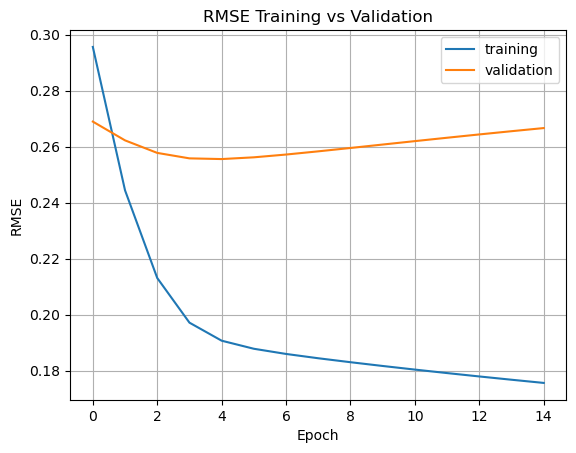

In [62]:
plt.plot(history.history['root_mean_squared_error'], label='training')
plt.plot(history.history['val_root_mean_squared_error'], label='validation')
plt.legend()
plt.title('RMSE Training vs Validation')
plt.xlabel('Epoch')
plt.ylabel(('RMSE'))
plt.grid(True)
plt.show()

In [63]:
y_true = y_val
y_pred = model.predict(x_val)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print("RMSE:", rmse)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
RMSE: 0.25553916508671987


Berdasarkan grafik RMSE, terlihat bahwa ada indikasi overfitting yang bisa jadi disebabkan oleh kurang banyaknya data yang diperoleh.
Nilai RMSE sangat baik yaitu 0.2555, untuk skala 0-1 rating yang dinormalisasi.